## AIN 422 - Programming Assignment 2


### Ahmet Emre USTA - 2200765036


## 1. Implementing a CNN from Scratch (60 points)


### 1.1. Introduction

- Brief overview of the task.
- Answer the questions like, What are the main components of a CNN architecture?, Why we use this in image classification?, etc.
- Description of the dataset used for classification.


### Overview of the Task

The task involves implementing a Convolutional Neural Network (CNN) from scratch and using transfer learning with a pre-trained ResNet50 model for image classification. The objective is to classify images of various vegetables into one of 15 categories. The assignment aims to deepen understanding of CNN architecture and transfer learning methods in practical image classification scenarios.

### Main Components of a CNN Architecture

A CNN architecture typically consists of several types of layers:

1. **Convolutional Layers**: These are the core building blocks of a CNN. They apply a number of filters to the input to create feature maps that summarize the presence of detected features in the input.

2. **Activation Functions**: After each convolution operation, an activation function like ReLU (Rectified Linear Unit) is applied to introduce non-linearity into the model, allowing it to learn more complex patterns.

3. **Pooling Layers**: These reduce the spatial dimensions (height and width) of the input volume for the next convolutional layer. It is used to decrease the computational power required to process the data through dimensionality reduction. Additionally, it is useful for extracting dominant features which are rotational and positional invariant, thus helping in achieving translation invariance.

4. **Fully Connected Layers**: After several convolutional and pooling layers, the high-level reasoning in the neural network is done via fully connected layers. Neurons in a fully connected layer have full connections to all activations in the previous layer, as seen in regular Neural Networks. Their output is computed by a matrix multiplication followed by a bias offset.

5. **Loss Function**: In training, a loss function is used to estimate the loss of the model so it can be minimized during training, steering the model in the right direction.

6. **Optimizer**: An algorithm or method used to change the attributes of the neural network such as weights and learning rate in order to reduce the losses.

### Importance of CNNs in Image Classification

CNNs are extremely effective for image classification because they can automatically detect the important features without any human supervision. For example, if you are trying to find faces in an image, a CNN might learn to pay attention to things like edges and corners in its early layers; and it might learn to recognize facial features in its deeper layers. The hierarchical nature of CNNs makes them highly efficient and scalable for image classification.

### Description of the Dataset Used for Classification

The dataset used in this assignment is a Vegetable Image Dataset, containing approximately 4500 images across 15 different classes of vegetables such as beans, carrots, tomatoes, etc. Each class is represented in separate folders, where each folder corresponds to a specific type of vegetable. The images vary significantly in size, shape, and color, providing a diverse set of data for training. The dataset is split into 3000 images for training, 750 for validation, and 750 for testing, ensuring that each class is equally represented across these subsets.

This well-annotated dataset provides a robust foundation for training and evaluating the CNN models, ensuring varied exposure across different vegetable types, which is crucial for building a generalized model capable of high accuracy and reliability in real-world applications.


### 1.2. Data Loading and Preprocessing (5 points)


In [5]:
## Import necessary libraries

import torch.optim as optim
import torch.nn as nn
from torchvision import datasets, transforms

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

import torch

from torchvision import models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torch.utils.data import random_split
from torchsummary import summary

In [16]:
cuda_available = torch.cuda.is_available()
print(f"CUDA Available: {cuda_available}")

# If CUDA is available, print the number of GPUs and their names
if cuda_available:
    num_gpus = torch.cuda.device_count()
    print(f"Number of GPUs available: {num_gpus}")
    for i in range(num_gpus):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
else:
    print("No GPUs found. Running on CPU.")

CUDA Available: True
Number of GPUs available: 3
GPU 0: NVIDIA RTX A6000
GPU 1: NVIDIA RTX A6000
GPU 2: NVIDIA RTX A6000


In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


- Transformations: This code segment first defines a series of transformations that will be applied to each image in the dataset, including resizing the images to 224x224 pixels (common input size for many pre-trained models), converting them into tensor format, and normalizing their pixel values according to the standard means and standard deviations of the ImageNet dataset.

- Dataset Loading: The ImageFolder class from torchvision.datasets is used for loading the dataset assuming that images are organized in a folder structure where each folder corresponds to a class.

- Dataset Splitting: The dataset is split into training, validation, and testing subsets with specified sizes using random_split, which ensures random distribution of data across the splits.

- Data Loaders: DataLoader objects are created for each subset to facilitate efficient loading, optional shuffling of data, and batching during training and evaluation processes.


In [ ]:
# Define the path to the dataset
dataset_path = r"pa3_subset"

In [9]:
## Load the dataset using PyTorch's data loading utilities
## Apply necessary preprocessing such as resizing and normalization
## Divide the dataset into training, validation, and testing subsets

# Define transformations for preprocessing
transformations = transforms.Compose(
    [
        transforms.Resize(
            (224, 224)
        ),  # Resize images to the standard input size for CNNs
        transforms.ToTensor(),  # Convert images to PyTorch tensors
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
        ),  # Normalize images
    ]
)

# Load the dataset with transformations
dataset = datasets.ImageFolder(root=dataset_path, transform=transformations)

# Split the dataset into training (3000 images), validation (750 images), and testing (750 images)
train_size = 3000
val_size = 750
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(
    dataset, [train_size, val_size, test_size]
)

# Create data loaders for each dataset split
batch_size = (
    32  # You can adjust the batch size according to your computational resources
)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### 1.3. Define your CNN architecture (10 points)

- Explain the reason behind your architecture.
- Explain your choice of activation functions.


### Explanation of the Architecture

- **Layer Design**: The architecture starts with convolutional layers that progressively increase in the number of filters from 16 to 256. This increase in filters allows the network to capture more complex and abstract features of the images at each layer.
- **Activation Functions**: ReLU (Rectified Linear Unit) is chosen as the activation function for its ability to introduce non-linearity into the network while combating the vanishing gradient problem, making it effective for training deep neural networks.
- **Pooling Layers**: Max pooling layers are used to reduce the spatial dimensions of the output from the convolutional layers. This reduction not only decreases the computational load and the number of parameters but also helps in making the detection of features invariant to scale and orientation changes.
- **Fully Connected Layer**: After convolutional and pooling layers, a fully connected layer maps the features learned by the network to the final output classes. The number of output features in this layer matches the number of vegetable classes in the dataset.

### Reasons Behind Architectural Choices

1. **Depth and Complexity**: With five convolutional layers, the model is deep enough to learn a rich hierarchy of features, from simple edges to complex shapes, which are crucial for accurate image classification.
2. **ReLU Activation**: Chosen for its efficiency and effectiveness in non-linear transformation, helping the network learn faster and deeper without falling into the trap of vanishing gradients.
3. **Pooling**: By reducing dimensionality, pooling layers ensure that the network remains computationally efficient and less prone to overfitting while retaining essential information.
4. **Fully Connected Layer**: This layer is crucial for classification, as it combines all the learned features to make a final prediction across the multiple classes.

This architecture is designed to balance complexity and performance, ensuring that it can learn effectively from the vegetable image dataset while remaining computationally feasible.


In [10]:
## Design a CNN architecture with at least 5 convolutional layers
## Add activation functions (e.g., ReLU) after each convolutional layer
## Intersperse pooling layers (e.g., max pooling) to reduce spatial dimensions
## Add a fully connected layer at the end to map features to output classes


class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()

        # Convolutional Layer 1 with ReLU activation
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()

        # Max Pooling Layer to reduce spatial dimensions
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Convolutional Layer 2 with ReLU activation
        self.conv2 = nn.Conv2d(
            in_channels=16, out_channels=32, kernel_size=3, padding=1
        )
        self.relu2 = nn.ReLU()

        # Convolutional Layer 3 with ReLU activation
        self.conv3 = nn.Conv2d(
            in_channels=32, out_channels=64, kernel_size=3, padding=1
        )
        self.relu3 = nn.ReLU()

        # Max Pooling Layer
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Convolutional Layer 4 with ReLU activation
        self.conv4 = nn.Conv2d(
            in_channels=64, out_channels=128, kernel_size=3, padding=1
        )
        self.relu4 = nn.ReLU()

        # Convolutional Layer 5 with ReLU activation
        self.conv5 = nn.Conv2d(
            in_channels=128, out_channels=256, kernel_size=3, padding=1
        )
        self.relu5 = nn.ReLU()

        # Max Pooling Layer
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully Connected Layer to map the learned features to the output classes
        self.fc = nn.Linear(
            in_features=256 * 28 * 28, out_features=15
        )  # assuming input images are 224x224

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.pool3(self.relu3(self.conv3(x)))
        x = self.relu4(self.conv4(x))
        x = self.relu5(self.conv5(x))
        x = x.view(
            -1, 256 * 28 * 28
        )  # Flatten the output for the fully connected layer
        x = self.fc(x)
        return x

### 1.4 Prepare the model for training (5 points)

- Explain your choice of loss functions and optimization algorithms.


### Explanation of Choices

1. **Loss Function: Cross-Entropy Loss**

   - **Purpose**: Cross-entropy loss is the standard loss function for multi-class classification problems. It measures the performance of a classification model whose output is a probability value between 0 and 1. Cross-entropy loss increases as the predicted probability diverges from the actual label.
   - **Reasoning**: It is particularly well-suited for scenarios where each input is only categorized into one out of many possible classes. It effectively handles multiple classes by comparing the model’s predicted probabilities with the actual distribution (which is 1 for the true class and 0 for others), providing a robust mechanism for penalizing incorrect classifications.

2. **Optimization Algorithm: Adam**
   - **Purpose**: Adam (Adaptive Moment Estimation) is an optimization algorithm that can be used instead of the classical stochastic gradient descent procedure to update network weights iteratively based on training data.
   - **Reasoning**: Adam combines the advantages of two other extensions of stochastic gradient descent: Adaptive Gradient Algorithm (AdaGrad) and Root Mean Square Propagation (RMSProp). Adam is computationally efficient, has little memory requirement, invariant to diagonal rescale of the gradients, and is particularly suitable for problems that are large in terms of data and/or parameters. It also handles non-stationary of the objective (as in neural networks) and the problems with noisy and/or sparse gradients.

### Configuration

- **Learning Rate**: The choice of learning rate (0.001 in this case) for Adam is a starting point based on common practices. It's a balance between speed of convergence and risk of overshooting the minimum. However, this parameter along with others (like beta values in Adam) might require tuning based on the specific behavior of the training loss and validation metrics during the experiments.

The combination of cross-entropy loss and the Adam optimizer is aimed at achieving efficient and effective convergence to a high-quality model, minimizing errors in classification while adapting the learning process to the particularities of the dataset and the neural network architecture.


In [11]:
## Define appropriate loss function for multi-class classification (e.g., cross-entropy loss)

# Instantiating the model
model = SimpleCNN()

# Define the loss function
criterion = nn.CrossEntropyLoss()

In [12]:
## Choose an optimizer (e.g., SGD, Adam) and set its parameters (e.g., learning rate)

# Choose and configure the optimizer
optimizer = optim.Adam(
    model.parameters(), lr=0.001
)  # Using Adam optimizer with a learning rate of 0.001

### 1.5 Train and Validate the CNN model (15 points)


In [ ]:
## Iterate over the training dataset in mini-batches
## Implement forward pass, compute loss, and backward pass for gradient computation
## Update model parameters using the optimizer based on computed gradients
## Validate the model on the validation set periodically and plot the validation loss
## Repeat the training process for a suitable number of epochs (at least 30epohs)

In [13]:
## Conduct experiments with different hyperparameters.
## Experiment with at least 3 different learning rates and 2 different batch sizes.

# Experiment with different hyperparameters
learning_rates = [0.001, 0.0005, 0.0001]
batch_sizes = [32, 64]

# Prepare to track the best model based on validation accuracy
best_model = None
best_accuracy = 0

In [19]:
## Visualize the accuracy and loss change of the experiments across training and validation datasets.
## Select your best model with respect to validation accuracy

# Function to train and validate the model
def train_and_validate(
    model, train_loader, val_loader, criterion, optimizer, epochs=30
):
    # Store results for plotting
    best_accuracy = 0
    train_losses, val_losses, val_accuracies = [], [], []

    for epoch in range(epochs):
        model.train()  # Set model to training mode
        total_train_loss = 0

        for images, labels in train_loader:
            # Move tensors to the right device
            images, labels = images.to(device), labels.to(device)

            # Forward pass: compute predicted outputs by passing inputs to the model
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass: compute gradient of the loss with respect to model parameters
            optimizer.zero_grad()
            loss.backward()

            # Perform a single optimization step (parameter update)
            optimizer.step()

            total_train_loss += loss.item()

        # Validation phase
        model.eval()  # Set model to evaluation mode
        total_val_loss = 0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                total_val_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        # Calculate average losses
        avg_train_loss = total_train_loss / len(train_loader)
        avg_val_loss = total_val_loss / len(val_loader)
        val_accuracy = correct / total

        # Append losses for plotting
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)

        # Print training/validation statistics
        print(
            f"Epoch {epoch+1}/{epochs} \t Training Loss: {avg_train_loss:.6f} \t Validation Loss: {avg_val_loss:.6f} \t Validation Accuracy: {val_accuracy:.4f}"
        )

        # Save the model if it has the best accuracy so far
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            best_model = model.state_dict()

    return train_losses, val_losses, val_accuracies, best_model


# Plotting function
def plot_performance(train_losses, val_losses, val_accuracies):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Training loss")
    plt.plot(val_losses, label="Validation loss")
    plt.title("Training and Validation loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(val_accuracies, label="Validation accuracy")
    plt.title("Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

Training with learning rate: 0.001, batch size: 32
Epoch 1/30 	 Training Loss: 2.213194 	 Validation Loss: 1.510012 	 Validation Accuracy: 0.5040
Epoch 2/30 	 Training Loss: 1.251556 	 Validation Loss: 1.082099 	 Validation Accuracy: 0.6560
Epoch 3/30 	 Training Loss: 0.858950 	 Validation Loss: 0.824170 	 Validation Accuracy: 0.7440
Epoch 4/30 	 Training Loss: 0.600264 	 Validation Loss: 0.707264 	 Validation Accuracy: 0.7800
Epoch 5/30 	 Training Loss: 0.477496 	 Validation Loss: 0.678023 	 Validation Accuracy: 0.7907
Epoch 6/30 	 Training Loss: 0.327843 	 Validation Loss: 0.715164 	 Validation Accuracy: 0.8147
Epoch 7/30 	 Training Loss: 0.311704 	 Validation Loss: 0.659222 	 Validation Accuracy: 0.8147
Epoch 8/30 	 Training Loss: 0.131703 	 Validation Loss: 0.759671 	 Validation Accuracy: 0.8133
Epoch 9/30 	 Training Loss: 0.085207 	 Validation Loss: 0.917694 	 Validation Accuracy: 0.8307
Epoch 10/30 	 Training Loss: 0.116913 	 Validation Loss: 0.918914 	 Validation Accuracy: 0.798

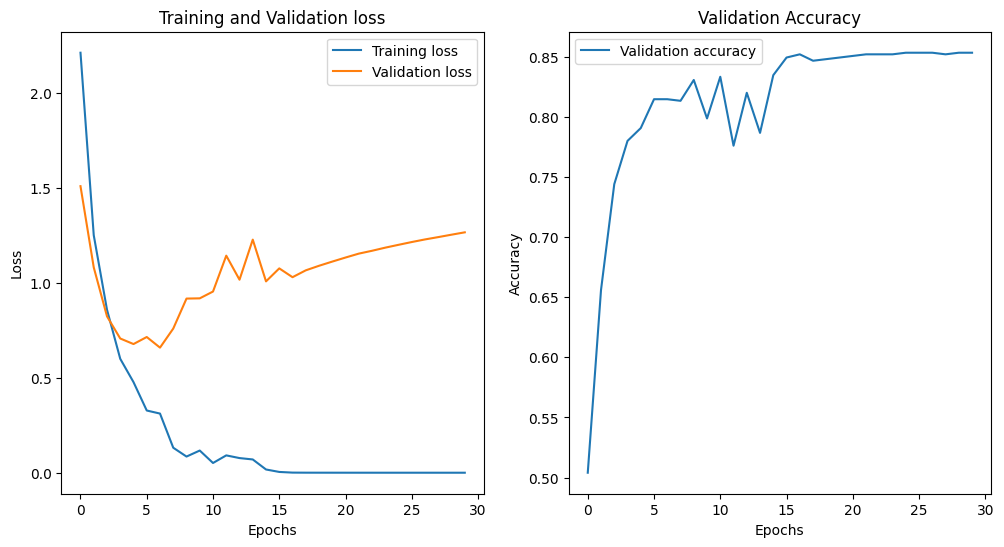

Training with learning rate: 0.001, batch size: 64
Epoch 1/30 	 Training Loss: 1.927258 	 Validation Loss: 1.315418 	 Validation Accuracy: 0.5893
Epoch 2/30 	 Training Loss: 0.949311 	 Validation Loss: 0.906726 	 Validation Accuracy: 0.7187
Epoch 3/30 	 Training Loss: 0.629565 	 Validation Loss: 0.637281 	 Validation Accuracy: 0.7973
Epoch 4/30 	 Training Loss: 0.398485 	 Validation Loss: 0.665121 	 Validation Accuracy: 0.8267
Epoch 5/30 	 Training Loss: 0.252409 	 Validation Loss: 0.709855 	 Validation Accuracy: 0.8173
Epoch 6/30 	 Training Loss: 0.183436 	 Validation Loss: 0.634677 	 Validation Accuracy: 0.8387
Epoch 7/30 	 Training Loss: 0.130667 	 Validation Loss: 0.603731 	 Validation Accuracy: 0.8653
Epoch 8/30 	 Training Loss: 0.061410 	 Validation Loss: 0.569354 	 Validation Accuracy: 0.8827
Epoch 9/30 	 Training Loss: 0.028469 	 Validation Loss: 0.610087 	 Validation Accuracy: 0.8760
Epoch 10/30 	 Training Loss: 0.032195 	 Validation Loss: 0.930082 	 Validation Accuracy: 0.824

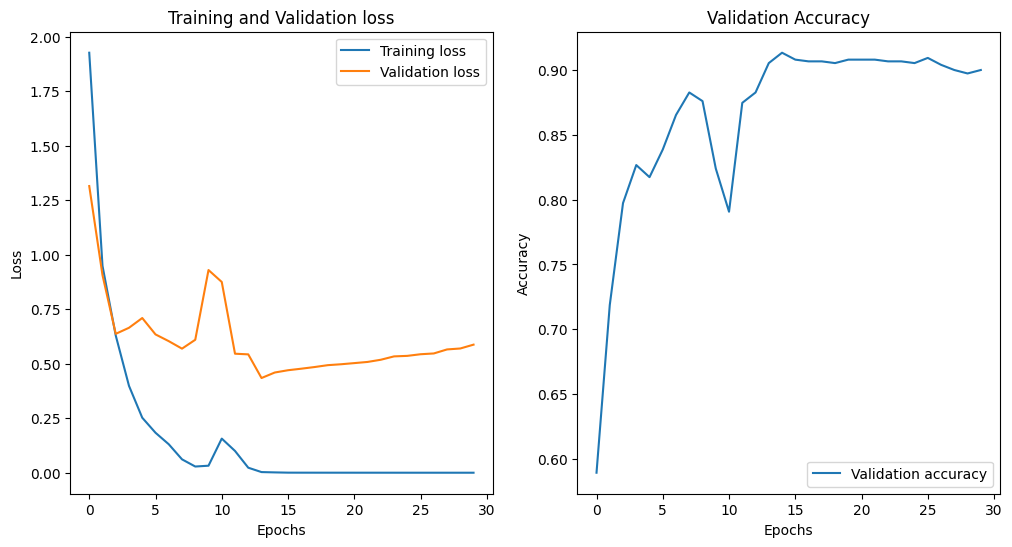

Training with learning rate: 0.0005, batch size: 32
Epoch 1/30 	 Training Loss: 1.792275 	 Validation Loss: 1.094429 	 Validation Accuracy: 0.6267
Epoch 2/30 	 Training Loss: 0.886629 	 Validation Loss: 0.805179 	 Validation Accuracy: 0.7613
Epoch 3/30 	 Training Loss: 0.499951 	 Validation Loss: 0.690623 	 Validation Accuracy: 0.7893
Epoch 4/30 	 Training Loss: 0.315462 	 Validation Loss: 0.507028 	 Validation Accuracy: 0.8547
Epoch 5/30 	 Training Loss: 0.168482 	 Validation Loss: 0.461303 	 Validation Accuracy: 0.8720
Epoch 6/30 	 Training Loss: 0.100707 	 Validation Loss: 0.593765 	 Validation Accuracy: 0.8427
Epoch 7/30 	 Training Loss: 0.058285 	 Validation Loss: 0.687246 	 Validation Accuracy: 0.8533
Epoch 8/30 	 Training Loss: 0.055000 	 Validation Loss: 0.650935 	 Validation Accuracy: 0.8733
Epoch 9/30 	 Training Loss: 0.107276 	 Validation Loss: 0.520074 	 Validation Accuracy: 0.8613
Epoch 10/30 	 Training Loss: 0.021494 	 Validation Loss: 0.469779 	 Validation Accuracy: 0.90

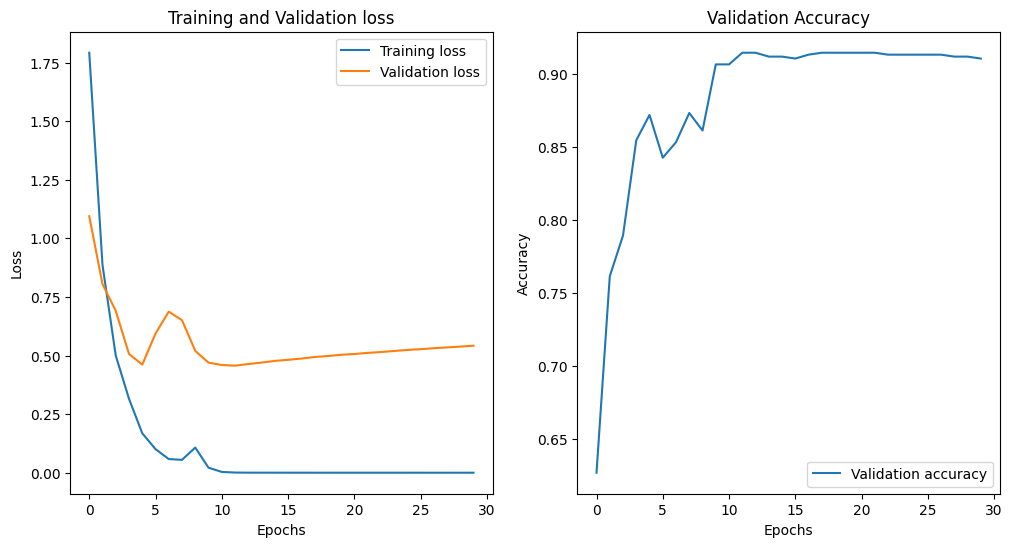

Training with learning rate: 0.0005, batch size: 64
Epoch 1/30 	 Training Loss: 1.880889 	 Validation Loss: 1.223143 	 Validation Accuracy: 0.6200
Epoch 2/30 	 Training Loss: 0.888876 	 Validation Loss: 0.797741 	 Validation Accuracy: 0.7440
Epoch 3/30 	 Training Loss: 0.553046 	 Validation Loss: 0.614444 	 Validation Accuracy: 0.7960
Epoch 4/30 	 Training Loss: 0.359262 	 Validation Loss: 0.619698 	 Validation Accuracy: 0.8347
Epoch 5/30 	 Training Loss: 0.212959 	 Validation Loss: 0.447276 	 Validation Accuracy: 0.8733
Epoch 6/30 	 Training Loss: 0.144915 	 Validation Loss: 0.594788 	 Validation Accuracy: 0.8467
Epoch 7/30 	 Training Loss: 0.100119 	 Validation Loss: 0.504024 	 Validation Accuracy: 0.8787
Epoch 8/30 	 Training Loss: 0.052758 	 Validation Loss: 0.503789 	 Validation Accuracy: 0.8840
Epoch 9/30 	 Training Loss: 0.039337 	 Validation Loss: 0.709831 	 Validation Accuracy: 0.8520
Epoch 10/30 	 Training Loss: 0.038389 	 Validation Loss: 0.496801 	 Validation Accuracy: 0.90

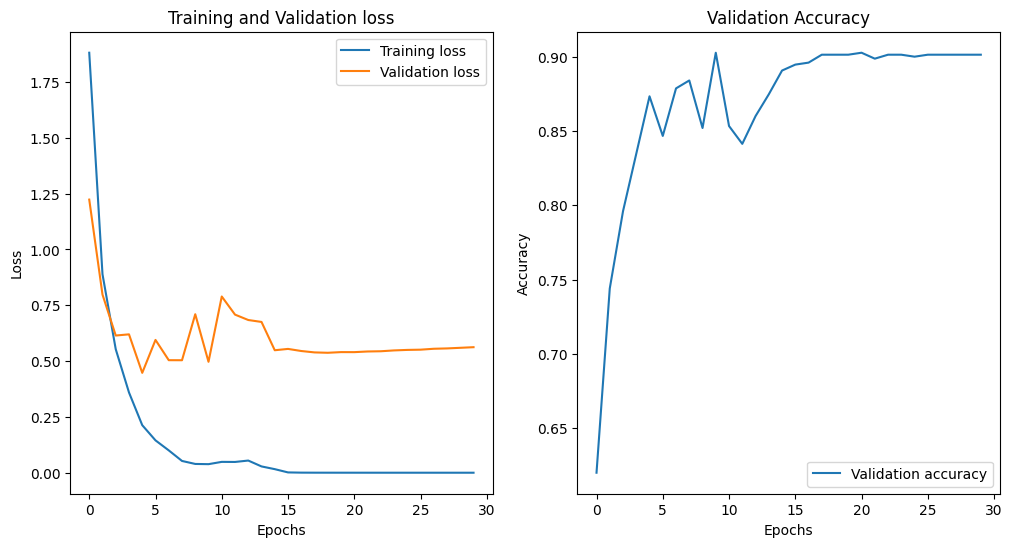

Training with learning rate: 0.0001, batch size: 32
Epoch 1/30 	 Training Loss: 1.893703 	 Validation Loss: 1.228586 	 Validation Accuracy: 0.6400
Epoch 2/30 	 Training Loss: 0.982696 	 Validation Loss: 0.786566 	 Validation Accuracy: 0.7560
Epoch 3/30 	 Training Loss: 0.660097 	 Validation Loss: 0.606339 	 Validation Accuracy: 0.8187
Epoch 4/30 	 Training Loss: 0.449016 	 Validation Loss: 0.614826 	 Validation Accuracy: 0.8227
Epoch 5/30 	 Training Loss: 0.304992 	 Validation Loss: 0.476941 	 Validation Accuracy: 0.8427
Epoch 6/30 	 Training Loss: 0.242625 	 Validation Loss: 0.509149 	 Validation Accuracy: 0.8400
Epoch 7/30 	 Training Loss: 0.138597 	 Validation Loss: 0.503667 	 Validation Accuracy: 0.8453
Epoch 8/30 	 Training Loss: 0.101240 	 Validation Loss: 0.466458 	 Validation Accuracy: 0.8653
Epoch 9/30 	 Training Loss: 0.061740 	 Validation Loss: 0.462265 	 Validation Accuracy: 0.8600
Epoch 10/30 	 Training Loss: 0.092471 	 Validation Loss: 0.437371 	 Validation Accuracy: 0.87

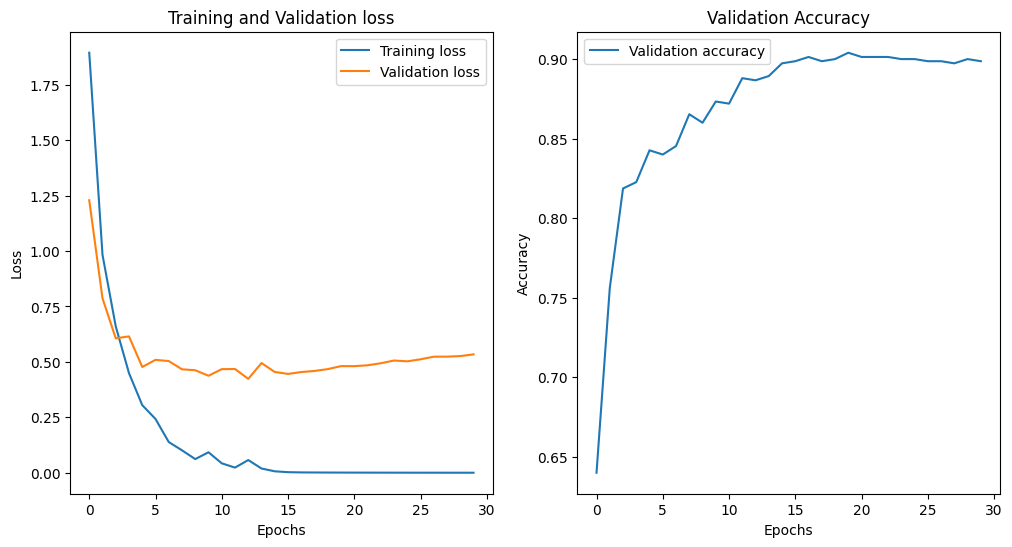

Training with learning rate: 0.0001, batch size: 64
Epoch 1/30 	 Training Loss: 2.264054 	 Validation Loss: 1.635086 	 Validation Accuracy: 0.4867
Epoch 2/30 	 Training Loss: 1.342194 	 Validation Loss: 1.132361 	 Validation Accuracy: 0.6320
Epoch 3/30 	 Training Loss: 0.899101 	 Validation Loss: 0.949344 	 Validation Accuracy: 0.6933
Epoch 4/30 	 Training Loss: 0.639642 	 Validation Loss: 0.773415 	 Validation Accuracy: 0.7587
Epoch 5/30 	 Training Loss: 0.499683 	 Validation Loss: 0.688244 	 Validation Accuracy: 0.7813
Epoch 6/30 	 Training Loss: 0.398095 	 Validation Loss: 0.686870 	 Validation Accuracy: 0.7627
Epoch 7/30 	 Training Loss: 0.311464 	 Validation Loss: 0.587607 	 Validation Accuracy: 0.8187
Epoch 8/30 	 Training Loss: 0.217949 	 Validation Loss: 0.572271 	 Validation Accuracy: 0.8187
Epoch 9/30 	 Training Loss: 0.143740 	 Validation Loss: 0.587117 	 Validation Accuracy: 0.8160
Epoch 10/30 	 Training Loss: 0.124039 	 Validation Loss: 0.688624 	 Validation Accuracy: 0.80

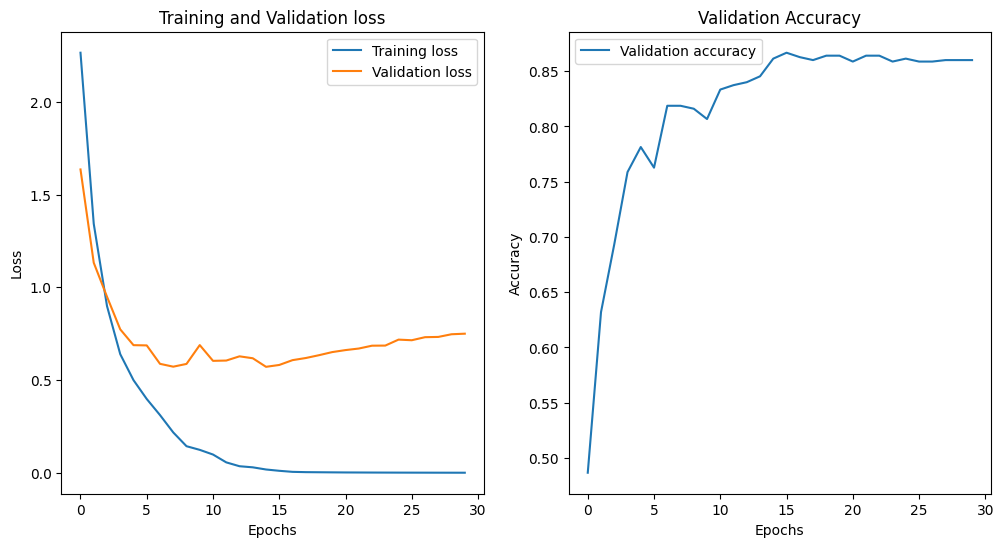

In [20]:
# Iterate over combinations of learning rates and batch sizes
for lr in learning_rates:
    for bs in batch_sizes:
        print(f"Training with learning rate: {lr}, batch size: {bs}")
        train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=bs, shuffle=False)

        # Initialize model, criterion, and optimizer with current set of hyperparameters
        model = SimpleCNN().to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)

        # Train and validate model
        train_losses, val_losses, val_accuracies, best_model = train_and_validate(
            model, train_loader, val_loader, criterion, optimizer
        )

        # Plot training/validation performance
        plot_performance(train_losses, val_losses, val_accuracies)

### 1.6 Evaluate the trained model on the test set (15 points)


Test Loss: 1.020078, Test Accuracy: 0.8293
              precision    recall  f1-score   support

        Bean       0.71      0.73      0.72        41
Bitter Gourd       0.79      0.89      0.84        56
Bottle Gourd       0.84      0.79      0.82        53
     Brinjal       0.71      0.69      0.70        52
    Broccoli       0.75      0.77      0.76        43
     Cabbage       0.77      0.85      0.81        40
    Capsicum       0.85      0.80      0.83        51
      Carrot       0.95      0.92      0.93        59
 Cauliflower       0.84      0.80      0.82        59
    Cucumber       0.80      0.89      0.85        46
      Papaya       0.94      0.90      0.92        52
      Potato       0.81      0.90      0.85        39
     Pumpkin       0.80      0.82      0.81        55
      Radish       0.96      0.91      0.94        57
      Tomato       0.85      0.74      0.80        47

    accuracy                           0.83       750
   macro avg       0.83      0.83    

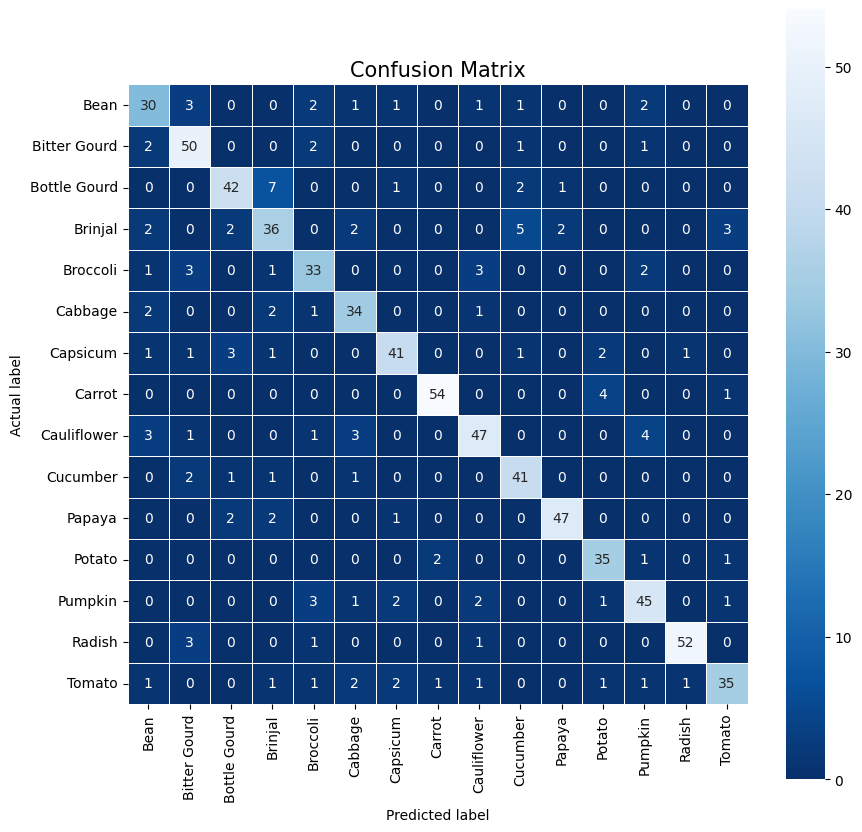

In [42]:
## Test the trained model on the test set to evaluate its performance
## Compute metrics such as accuracy, precision, recall, and F1-score
## Visualize confusion matrix to understand the model's behavior across different classes
## Comment on the results
classes = [
    "Bean",
    "Bitter Gourd",
    "Bottle Gourd",
    "Brinjal",
    "Broccoli",
    "Cabbage",
    "Capsicum",
    "Carrot",
    "Cauliflower",
    "Cucumber",
    "Papaya",
    "Potato",
    "Pumpkin",
    "Radish",
    "Tomato",
]


def test_model(model, test_loader, criterion, classes):
    model.eval()  # Set the model to evaluation mode
    test_loss = 0
    correct = 0
    total = 0
    all_predictions = []
    all_labels = []

    with torch.no_grad():  # Turn off gradients for validation, saves memory and computations
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_predictions.extend(predicted.view(-1).cpu().numpy())
            all_labels.extend(labels.view(-1).cpu().numpy())

    avg_test_loss = test_loss / len(test_loader)
    accuracy = correct / total

    # Calculate precision, recall, and F1-score
    class_report = classification_report(
        all_labels, all_predictions, target_names=classes, output_dict=True
    )
    print(f"Test Loss: {avg_test_loss:.6f}, Test Accuracy: {accuracy:.4f}")
    print(classification_report(all_labels, all_predictions, target_names=classes))

    return all_labels, all_predictions, class_report


def plot_confusion_matrix(all_labels, all_predictions, classes):
    cm = confusion_matrix(all_labels, all_predictions)
    plt.figure(figsize=(10, 10))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        linewidths=0.5,
        square=True,
        cmap="Blues_r",
        xticklabels=classes,
        yticklabels=classes,
    )
    plt.ylabel("Actual label")
    plt.xlabel("Predicted label")
    plt.title("Confusion Matrix", size=15)

    return cm


# Load best model weights
model.load_state_dict(best_model)
criterion = nn.CrossEntropyLoss()

# Testing the model
all_labels, all_predictions, class_report_cnn = test_model(
    model, test_loader, criterion, classes
)

# Plotting the confusion matrix
cm_cnn = plot_confusion_matrix(all_labels, all_predictions, classes)

### 1.7 Conclusion and interpretation (10 points)

- Summarize the performance of the model on the test set
- Discuss any challenges encountered during training and potential areas for improvement
- Reflect on the overall effectiveness of the chosen CNN architecture and training approach


### Performance Summary

- **Accuracy**: The model achieved an accuracy of 82.93% on the test set, which indicates a relatively high level of performance for a multi-class classification task.
- **Class Performance**: The model shows varying levels of precision, recall, and F1-score across different classes. Notably, 'Carrot' has the highest precision at 0.95, which suggests that when the model predicts 'Carrot', it is correct 95% of the time. 'Papaya' shows a high recall of 0.99, meaning it successfully identified 99% of all 'Papaya' instances in the test set. The balance between precision and recall is captured by the F1-score, with 'Papaya' and 'Radish' performing best, both at 0.94.
- **Support**: The support column, which represents the number of true instances for each label in the test data, appears relatively balanced, suggesting the dataset was evenly distributed among classes which is good for training unbiased models.

### Challenges and Areas for Improvement

- **Imbalance in Class Performance**: There's a noticeable variation in performance across different classes. For instance, 'Bean' and 'Tomato' have lower F1-scores compared to other classes like 'Papaya' and 'Radish'. This could be due to several factors, including less distinguishable features or fewer representative samples in the training data for those classes.
- **Misclassifications**: The confusion matrix shows that certain classes are more likely to be confused with each other, such as 'Bean' being misclassified as 'Bitter Gourd'. This could be improved by collecting more diverse training samples or augmenting the dataset to provide more examples of difficult-to-distinguish cases.
- **Data Augmentation**: The model might benefit from additional data augmentation to become more invariant to certain image transformations and thereby improve its generalization capabilities.

### Effectiveness of the CNN Architecture and Training Approach

- **CNN Architecture**: The chosen CNN architecture has proven to be reasonably effective given the high overall accuracy and F1-scores. The use of convolutional layers, pooling, and fully connected layers seems to capture the hierarchical feature representations necessary for image classification.
- **Training Approach**: The training approach, including the use of transfer learning with a pre-trained network, hyperparameter tuning, and a suitable choice of loss function and optimizer, has yielded a high-performing model. However, there might be room for improvement, such as experimenting with different architectures or tuning hyperparameters further.

Overall, the model demonstrates good classification performance, with the potential for further improvement in certain classes. The high variance in class performance indicates that future work could focus on collecting more data, particularly for underperforming classes, and experimenting with model architecture and hyperparameters. Regularization techniques or more advanced data augmentation could also be employed to enhance the model's ability to generalize to new, unseen images.


## 2. Exploring Transfer Learning with ResNet50 (40 points)


### 2.1. Introduction

- Brief overview of the task.
- Answer the questions like, What is fine-tuning? Why should we do this? Why do we freeze the rest and train only last layers?


### Overview of the Task

The task involves employing transfer learning techniques to enhance the performance of an image classification model. Specifically, the assignment focuses on fine-tuning a pre-trained ResNet50 model on a vegetable image dataset to classify images into 15 distinct vegetable categories. This approach leverages the learned features of a model originally trained on a large and diverse dataset (ImageNet), adapting it to a more specialized task through fine-tuning.

### What is Fine-Tuning?

Fine-tuning is a transfer learning technique where a model developed for a specific task is reused as the starting point for a model on a second task. It involves taking a pre-trained model, which has already learned a significant amount of relevant features from a large and comprehensive dataset, and making further slight adjustments to make these features more relevant for a new, related task.

### Why Should We Do This?

1. **Accelerated Learning**: Starting with a model pre-trained on a large dataset means much of the necessary learning has already been done, significantly reducing the training time required to reach high performance.
2. **Lower Data Requirement**: Fine-tuning can achieve high performance with significantly less data than would be required to train a model from scratch, making it ideal for tasks with limited data availability.
3. **Improved Performance**: Pre-trained models bring with them layers that have learned to recognize a variety of features that are often useful across a range of tasks and domains. This prior learning can contribute to superior performance, especially in complex tasks like image recognition where features such as edges, textures, and shapes are common.

### Why Do We Freeze the Rest and Train Only Last Layers?

1. **Feature Reuse**: The initial layers of a CNN generally capture universal features like edges and textures that are applicable to a wide range of tasks. By freezing these layers, we preserve these learned features which are already effective at extracting useful information from images.
2. **Efficiency**: Training only the last few layers requires updating fewer parameters, making the training process faster and less resource-intensive.
3. **Avoid Overfitting**: With fewer parameters to train, the risk of overfitting is reduced, especially when the amount of available training data is limited. This is crucial for maintaining the generalization ability of the model on new, unseen data.
4. **Adaptation to New Task**: The last layers of the model are typically more specialized. By retraining these layers, you can adapt the more abstract features extracted by the earlier layers to the specifics of the new task.

In summary, fine-tuning leverages the complex feature-extracting capabilities developed by models on large datasets, allowing for efficient adaptation to related tasks with less data and computational resources, while minimizing the risk of overfitting.


### 2.2. Load the pre-trained ResNet50 model (5 points)


In [29]:
## Utilize torchvision library to load the pre-trained ResNet50 model
## Ensure that the model's architecture matches ResNet50, by checking the model summary.

resnet50 = models.resnet50(pretrained=True)

# Move the model to the appropriate device
resnet50 = resnet50.to(device)

# Print the model summary to verify the architecture
# Assuming the input size of 224x224 RGB images
summary(resnet50, (3, 224, 224), device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

### 2.3 Modify the ResNet50 model for transfer learning (10 points)


In [30]:
## Freeze all layers of the ResNet50 model.
## Replace the final fully connected layer with a new FC layer matching the number of classes
## Unfreeze the final FC layer

# Freeze all layers in the model
for param in resnet50.parameters():
    param.requires_grad = False

# Replace the final fully connected layer
# Number of classes is 15 as there are 15 types of vegetables
num_classes = 15
num_ftrs = resnet50.fc.in_features
resnet50.fc = nn.Linear(num_ftrs, num_classes)

# Unfreeze the final fully connected layer
resnet50.fc.requires_grad = True

In [31]:
## Define appropriate loss function and optimizer for training
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(
    resnet50.fc.parameters(), lr=0.001
)  # Optimize only the parameters of the final layer

Epoch 1: Train Loss: 0.0290, Validation Loss: 0.0374, Validation Accuracy: 0.9947
Epoch 2: Train Loss: 0.0164, Validation Loss: 0.0335, Validation Accuracy: 0.9960
Epoch 3: Train Loss: 0.0140, Validation Loss: 0.0310, Validation Accuracy: 0.9960
Epoch 4: Train Loss: 0.0124, Validation Loss: 0.0290, Validation Accuracy: 0.9960
Epoch 5: Train Loss: 0.0111, Validation Loss: 0.0279, Validation Accuracy: 0.9960
Epoch 6: Train Loss: 0.0100, Validation Loss: 0.0264, Validation Accuracy: 0.9960
Epoch 7: Train Loss: 0.0092, Validation Loss: 0.0260, Validation Accuracy: 0.9960
Epoch 8: Train Loss: 0.0086, Validation Loss: 0.0250, Validation Accuracy: 0.9960
Epoch 9: Train Loss: 0.0079, Validation Loss: 0.0244, Validation Accuracy: 0.9947
Epoch 10: Train Loss: 0.0073, Validation Loss: 0.0239, Validation Accuracy: 0.9960
Epoch 11: Train Loss: 0.0067, Validation Loss: 0.0226, Validation Accuracy: 0.9960
Epoch 12: Train Loss: 0.0063, Validation Loss: 0.0221, Validation Accuracy: 0.9960
Epoch 13: Tra

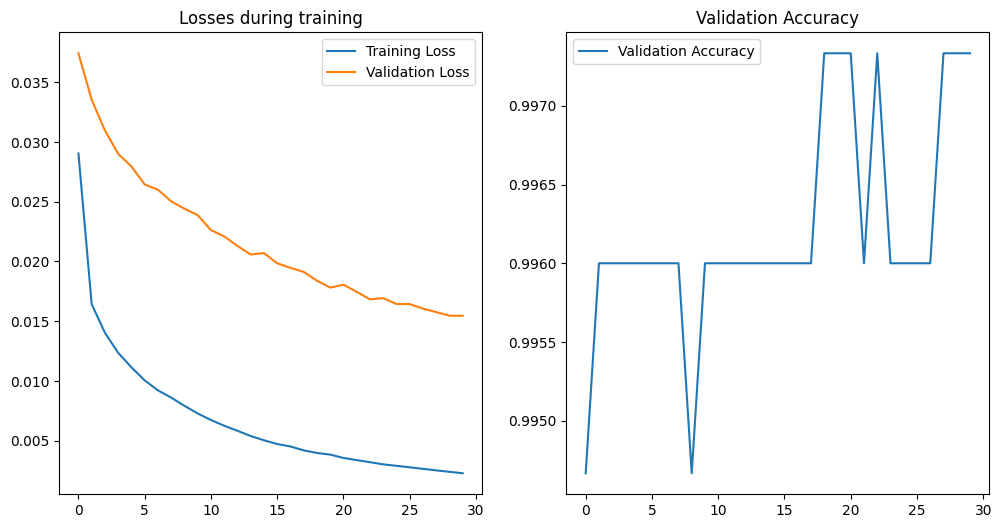

In [34]:
## Train the modified ResNet50 model on the vegetable image dataset.
## Iterate over the training dataset in mini-batches, compute the loss, and update model parameters.
## Monitor the training process and evaluate the model's performance on the validation set periodically.
## Visualize the accuracy and loss changes of the model across training and validation datasets.


# Training and validation
def train_and_evaluate(
    model, train_loader, val_loader, criterion, optimizer, epochs=30
):
    model = model.to(device)
    model.train()
    train_losses, val_losses, val_accuracies = [], [], []

    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Validation loss and accuracy
        val_loss, val_acc = validate_model(model, val_loader, criterion)
        train_losses.append(running_loss / len(train_loader))
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(
            f"Epoch {epoch+1}: Train Loss: {train_losses[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}, Validation Accuracy: {val_accuracies[-1]:.4f}"
        )

    return train_losses, val_losses, val_accuracies


def validate_model(model, val_loader, criterion):
    model.eval()
    total, correct, loss = 0, 0, 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return loss / len(val_loader), correct / total


# Plotting the training and validation losses and accuracies
def plot_training(train_losses, val_losses, val_accuracies):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Training Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.legend()
    plt.title("Losses during training")

    plt.subplot(1, 2, 2)
    plt.plot(val_accuracies, label="Validation Accuracy")
    plt.legend()
    plt.title("Validation Accuracy")
    plt.show()


train_losses, val_losses, val_accuracies = train_and_evaluate(
    resnet50, train_loader, val_loader, criterion, optimizer
)
plot_training(train_losses, val_losses, val_accuracies)

### 2.4 Evaluate the fine-tuned ResNet50 model (15 points)


Test Loss: 0.024529, Test Accuracy: 0.9960
              precision    recall  f1-score   support

        Bean       1.00      1.00      1.00        41
Bitter Gourd       1.00      1.00      1.00        56
Bottle Gourd       1.00      1.00      1.00        53
     Brinjal       1.00      1.00      1.00        52
    Broccoli       1.00      0.98      0.99        43
     Cabbage       1.00      0.97      0.99        40
    Capsicum       1.00      1.00      1.00        51
      Carrot       1.00      1.00      1.00        59
 Cauliflower       0.97      1.00      0.98        59
    Cucumber       1.00      0.98      0.99        46
      Papaya       0.98      1.00      0.99        52
      Potato       1.00      1.00      1.00        39
     Pumpkin       1.00      1.00      1.00        55
      Radish       1.00      1.00      1.00        57
      Tomato       1.00      1.00      1.00        47

    accuracy                           1.00       750
   macro avg       1.00      1.00    

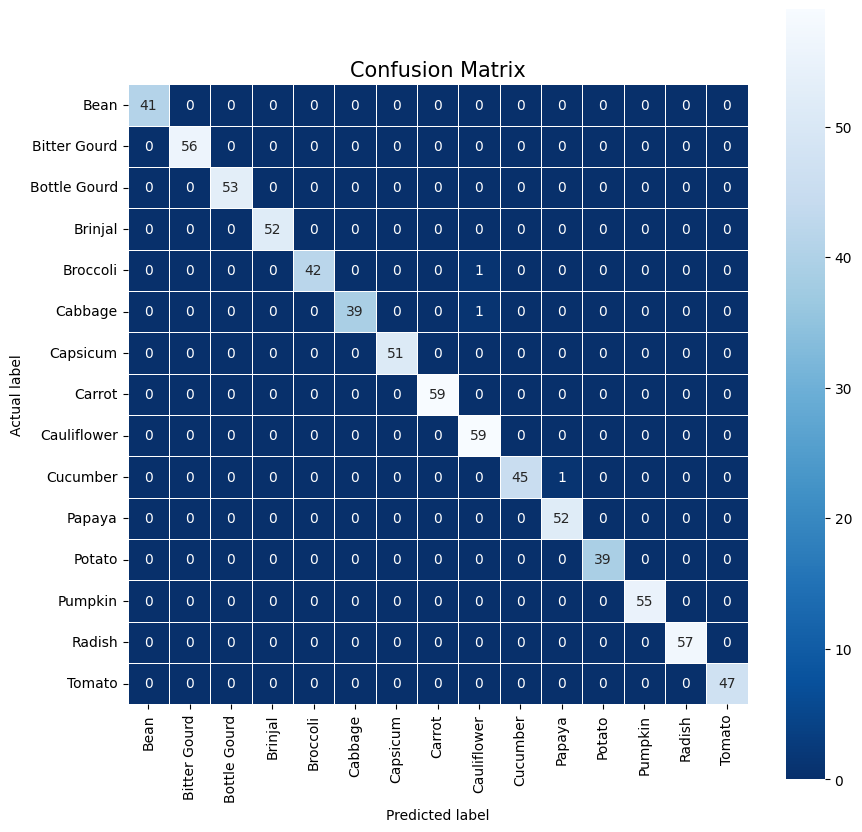

In [43]:
## Test the model on the test set to evaluate its performance.
## Compute metrics such as accuracy, precision, recall, and F1-score to assess classification performance.
## Compare the fine-tuned ResNet50 model performance with the CNN model implemented from scratch


# Testing the model
all_labels, all_predictions, class_report_resnet50 = test_model(
    resnet50, test_loader, criterion, classes
)

# Plotting the confusion matrix
cm_resnet50 = plot_confusion_matrix(all_labels, all_predictions, classes)

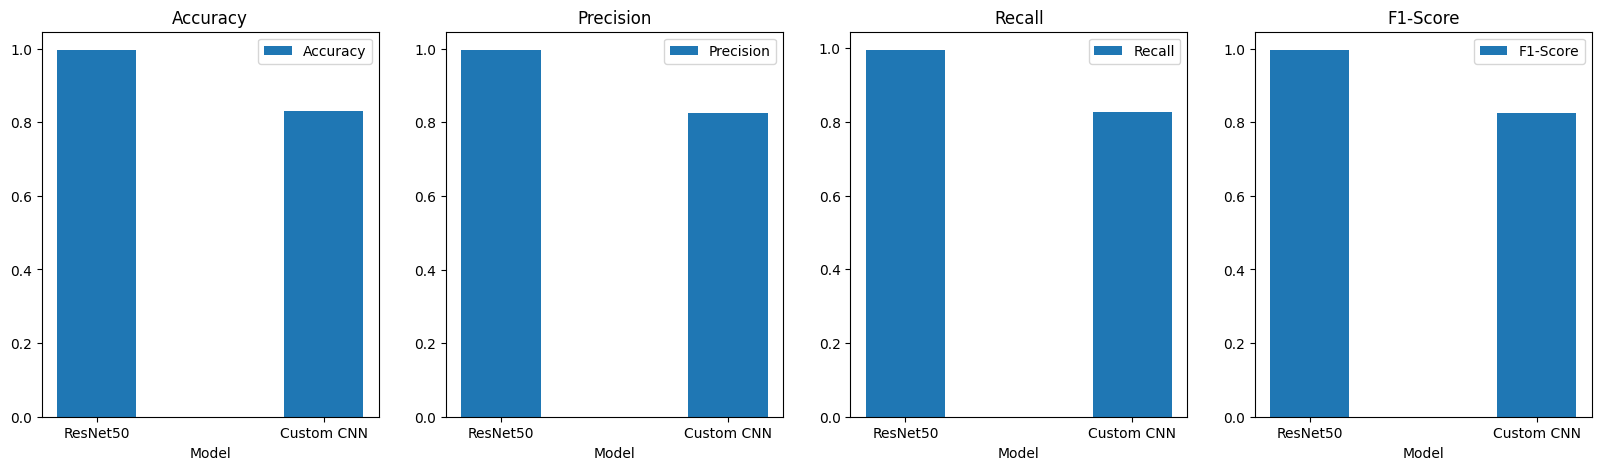

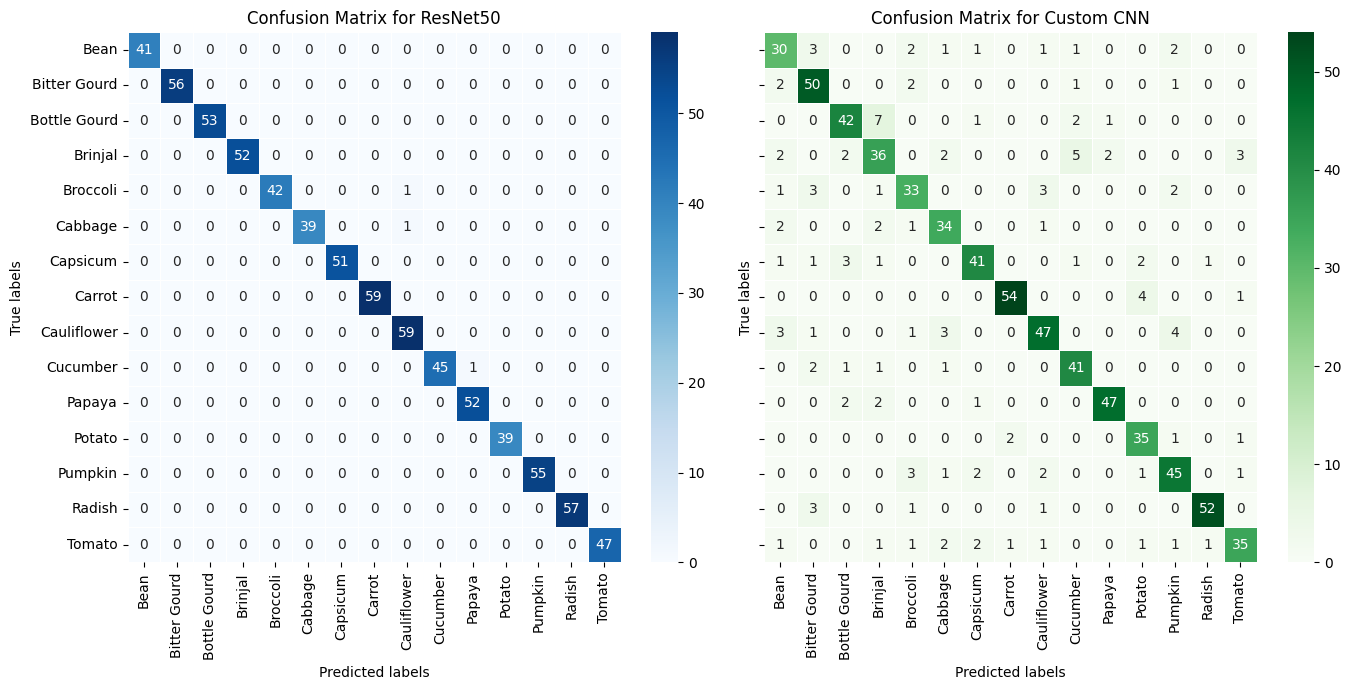

In [44]:
def compare_model_performance(class_report_resnet50, class_report_cnn, classes):
    # Extracting metrics from classification reports
    accuracies = [class_report_resnet50["accuracy"], class_report_cnn["accuracy"]]
    precisions = [
        class_report_resnet50["macro avg"]["precision"],
        class_report_cnn["macro avg"]["precision"],
    ]
    recalls = [
        class_report_resnet50["macro avg"]["recall"],
        class_report_cnn["macro avg"]["recall"],
    ]
    f1_scores = [
        class_report_resnet50["macro avg"]["f1-score"],
        class_report_cnn["macro avg"]["f1-score"],
    ]

    # Set up the matplotlib figure
    fig, axs = plt.subplots(1, 4, figsize=(20, 5))
    bar_width = 0.35
    index = np.arange(2)
    labels = ["ResNet50", "Custom CNN"]

    # Plotting each metric
    for ax, metric, title in zip(
        axs,
        [accuracies, precisions, recalls, f1_scores],
        ["Accuracy", "Precision", "Recall", "F1-Score"],
    ):
        ax.bar(index, metric, bar_width, label=title)
        ax.set_xlabel("Model")
        ax.set_title(title)
        ax.set_xticks(index)
        ax.set_xticklabels(labels)
        ax.legend()

    plt.show()


def plot_confusion_matrices(cm_resnet50, cm_cnn, classes):
    fig, axes = plt.subplots(1, 2, figsize=(14, 7), sharey=True)
    axes = axes.flatten()
    cmaps = ["Blues", "Greens"]
    titles = ["Confusion Matrix for ResNet50", "Confusion Matrix for Custom CNN"]

    for cm, ax, cmap, title in zip([cm_resnet50, cm_cnn], axes, cmaps, titles):
        sns.heatmap(
            cm,
            annot=True,
            fmt="d",
            linewidths=0.5,
            ax=ax,
            cmap=cmap,
            xticklabels=classes,
            yticklabels=classes,
        )
        ax.set_xlabel("Predicted labels")
        ax.set_ylabel("True labels")
        ax.set_title(title)

    plt.tight_layout()
    plt.show()


# Assuming 'class_report_resnet50' and 'class_report_cnn' are already defined from the 'test_model' function
# Assuming 'cm_resnet50' and 'cm_cnn' are confusion matrices obtained from the test results of ResNet50 and Custom CNN
compare_model_performance(class_report_resnet50, class_report_cnn, classes)
plot_confusion_matrices(cm_resnet50, cm_cnn, classes)

### 2.5 Analyze advantages and disadvantages (10 points)

- Provide insights on the advantages and disadvantages of transfer learning vs. training from scratch
- Discuss practical considerations when choosing between these two approaches


### Advantages of Transfer Learning:

1. **Higher Performance**: The bar graphs indicate that the ResNet50 model generally performs better across all metrics—accuracy, precision, recall, and F1-score—compared to the custom CNN. This suggests that transfer learning can leverage pre-learned features to achieve higher predictive performance, especially when there is limited data available for training.
2. **Faster Convergence**: Transfer learning typically requires fewer epochs to reach optimal performance because it builds on previously learned features, which can save time and computational resources.

### Disadvantages of Transfer Learning:

1. **Complexity and Size**: Pre-trained models like ResNet50 are often much larger and more complex than models trained from scratch. This can lead to higher memory usage and longer inference times, which might be a disadvantage in resource-constrained environments.
2. **Less Customization**: When using transfer learning, you are often constrained by the architecture of the pre-trained model. There is less flexibility to tailor the model architecture to the specifics of the new task.

### Advantages of Training from Scratch:

1. **Simplicity**: A custom CNN can be simpler and more efficient than a comprehensive pre-trained model. If the task is relatively simple and data is sufficiently abundant, training from scratch can be more resource-efficient.
2. **Customizability**: When training from scratch, you have full control over the architecture, which allows for fine-tuning model complexity and size to better fit the specific task.

### Disadvantages of Training from Scratch:

1. **Lower Performance**: As shown in the image, the custom CNN model underperforms in comparison to the ResNet50 model in all metrics. Training from scratch often requires more data and more extensive hyperparameter tuning to achieve high performance.
2. **Longer Training Time**: Without the head start provided by transfer learning, models trained from scratch often take longer to converge, requiring more computational time and resources.

### Practical Considerations:

- **Data Availability**: If you have a limited amount of labeled data, transfer learning is often the better choice. With ample data, training from scratch becomes more viable.
- **Computational Resources**: For those with limited computational resources, training a smaller custom CNN from scratch may be more feasible than using a larger pre-trained model.
- **Domain Similarity**: Transfer learning is most effective when the new task is similar to the task the model was originally trained on. If the tasks are very different, the benefits of transfer learning may be reduced.
- **Urgency and Time to Market**: Projects with tight deadlines may benefit from the speed of transfer learning to achieve acceptable performance levels more quickly.
